### Latitude Prediction for Roman sundials

Authors: Martin Hanik and Christoph von Tycowicz

This notebook accompanies the paper ‘‘Intrinsic shape analysis in archaeology: A case study on ancient sundials’’ and allows to replicate one of the experiments. In the following, we apply geodesic regression in the shape space of differential coordinates to model the dependence of the shape of the sundials' shadow surfaces on the latitude of the installation site. The resulting trajectory provides the means to approximate the latitude for sundials whose installation site is unknown. We compare this method with [partial least squares regression](https://en.wikipedia.org/wiki/Partial_least_squares_regression).

Let's first import the necessary libraries.

In [1]:
%env JAX_PLATFORM_NAME=cpu
%env JAX_ENABLE_X64=True
%matplotlib inline

import numpy as np
import jax.numpy as jnp
import pyvista as pv
import os

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
from sklearn.cross_decomposition import PLSRegression

from helper import generalized_procrustes

from morphomatics.geom import Surface
from morphomatics.stats import RiemannianRegression
from morphomatics.manifold import DifferentialCoords

env: JAX_PLATFORM_NAME=cpu
env: JAX_ENABLE_X64=True


Now, we load triangle meshes of ten Roman shadow surfaces and a mean surface; we also provide the latitudes that correspond to the ten installation sites. Finally, the meshes are Procrustes aligned.

In [2]:
# download meshes
if not os.path.isdir('meshes'):
    from urllib.request import urlopen
    from zipfile import ZipFile

    zipurl = 'https://www.zib.de/ext-data/sundial_shadow_surfaces/meshes.zip'
    zipresp = urlopen(zipurl)
    tempzip = open('/tmp/tempfile.zip', 'wb')
    tempzip.write(zipresp.read())
    tempzip.close()
    zf = ZipFile('/tmp/tempfile.zip')
    zf.extractall(path = 'meshes/')
    zf.close()

# reference to construct the shape space
pyT = pv.read('./meshes/mean.ply')
v = np.array(pyT.points)
f = pyT.faces.reshape(-1, 4)[:, 1:]
ref = Surface(v, f)

directory = './meshes/Roman/'

# latitudes corresponding to shadow surfaces of sundials in directory
lat = jnp.array([42.091300, 41.670000, 40.750300, 40.750300, 40.750300, 41.803400, 41.756100, 40.750300, 40.703000, 43.315540])
# mapping latitudes to [0,1]
t = (lat - jnp.min(lat)) / (jnp.max(lat) - jnp.min(lat))

# read data files
surf = []
list = os.listdir(directory)
list.sort()
for file in list:
    filename = os.fsdecode(file)
    if filename.endswith('.ply'):
        print(directory + filename)
        pyT = pv.read(directory + filename)
        v = np.array(pyT.points)
        f = pyT.faces.reshape(-1, 4)[:, 1:]
        surf.append(Surface(v, f))
        continue
    else:
        continue

generalized_procrustes(surf)

./meshes/Roman/ID017_shadowSurface_unitSize_mapped.ply
./meshes/Roman/ID018_shadowSurface_unitSize_mapped.ply
./meshes/Roman/ID021_shadowSurface_unitSize_mapped.ply
./meshes/Roman/ID023_shadowSurface_unitSize_mapped.ply
./meshes/Roman/ID029_shadowSurface_unitSize_mapped.ply
./meshes/Roman/ID036_shadowSurface_unitSize_mapped.ply
./meshes/Roman/ID065_shadowSurface_unitSize_mapped.ply
./meshes/Roman/ID174_shadowSurface_unitSize_mapped.ply
./meshes/Roman/ID519_shadowSurface_unitSize_mapped.ply
./meshes/Roman/ID574_shadowSurface_unitSize_mapped.ply


We can now build the shape space of differential coordinates and encode the shadow surfaces.

In [3]:
M = DifferentialCoords(ref)

C = []
P = []
for s in surf:
    P.append(s.v.reshape(-1))
    C.append(M.to_coords(s.v))
# center for PLS-regression
P = jnp.stack(P) - jnp.mean(jnp.stack(P), axis=0)
C = jnp.stack(C)

We now evaluate the accuracy of the prediction method from the paper. To this end, we use ten-fold cross validation and compare the average accuracy of the proposed method to the accuracy of using partial least squares regression.

In [4]:
N = len(surf)
e_man = jnp.zeros(N)
e_PLS = jnp.zeros(N)
for i in range(N):
    print(f'Predicting sundial {i+1}')
    # exclude i-th shadow surface
    Clow = C[jnp.arange(N) != i]
    Plow = P[jnp.arange(N) != i]
    tlow = t[jnp.arange(N) != i]

    # geodesic regression
    regression = RiemannianRegression(M, Clow, tlow, 1)

    # computed trajectory
    gam = regression.trend

    # PLS-regression
    pls1 = PLSRegression(n_components=1)
    X = Plow
    y = np.atleast_2d(tlow - np.mean(tlow)).transpose()
    pls1.fit(X, y)
    tpred_PLS = pls1.predict(np.atleast_2d(P[i]))[0][0]

    # project to regressed geodesic
    X = gam.eval(0.)
    Y = gam.eval(1.)
    S = M.projToGeodesic(X, Y, C[i])

    # get t value of projected point
    tpred_man = M.dist(X, S) / M.dist(X, Y)

    # save errors
    e_man = e_man.at[i].set(jnp.abs(t[i] - tpred_man))
    e_PLS = e_PLS.at[i].set(jnp.abs(t[i] - tpred_PLS))

l = (jnp.max(lat) - jnp.min(lat))

# map back to latitude interval
e_man = l * e_man
e_PLS = l * e_PLS

print(f'Manifold mean error: {jnp.mean(e_man):.2f}; PLS mean error: {jnp.mean(e_PLS):.2f}')
print(f'Manifold standard deviation: {jnp.std(e_man):.2f}; PLS standard deviation: {jnp.std(e_PLS):.2f}')

Predicting sundial 1
Predicting sundial 2
Predicting sundial 3
Predicting sundial 4
Predicting sundial 5
Predicting sundial 6
Predicting sundial 7
Predicting sundial 8
Predicting sundial 9
Predicting sundial 10
Manifold mean error: 0.75; PLS mean error: 0.87
Manifold standard deviation: 0.46; PLS standard deviation: 0.78


Finally, we plot the results.

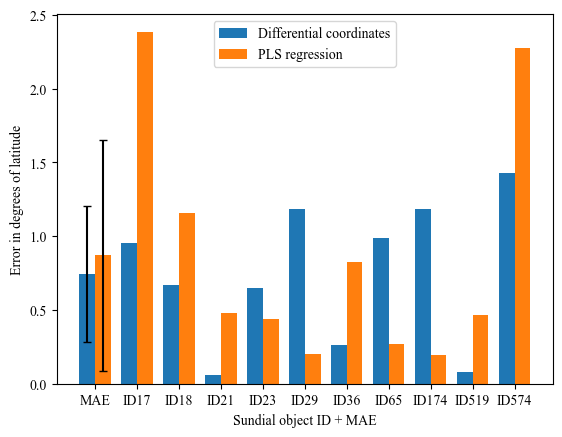

In [5]:
names = ['MAE', 'ID17', 'ID18', 'ID21', 'ID23', 'ID29', 'ID36', 'ID65', 'ID174', 'ID519', 'ID574']

data = [[jnp.mean(e_man), jnp.mean(e_PLS)]]
for i in range(len(e_man)):
    data.append([e_man[i], e_PLS[i]])

dim = len(data[0])
w = 0.75
dimw = w / dim

fig, ax = plt.subplots()
x = np.arange(len(data))
for i in range(len(data[0])):
    if i == 0:
        lab = 'Differential coordinates'
    else:
        lab = 'PLS regression'
    y = [d[i] for d in data]
    b = ax.bar(x + i * dimw, y, dimw, label=lab)

plt.errorbar(x[0], data[0][0], yerr=np.std(np.array(e_man)), ecolor='black', capsize=3)
plt.errorbar(x[0] + dimw, data[0][1], yerr=np.std(np.array(e_PLS)), ecolor='black', capsize=3)

plt.legend(loc='upper center')

ax.set_xticks(x + dimw / 2, labels=names)

ax.set_xlabel('Sundial object ID + MAE')
ax.set_ylabel('Error in degrees of latitude')

plt.show()